In [349]:
import cv2
import numpy as np
from commonfunctions import *
import imutils

In [350]:
def unsharp_mask(image, sigma=1.0, strength=1.5):
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(image, (0, 0), sigma)
    # Subtract the blurred image from the original
    sharpened = cv2.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

3.0606060606060606


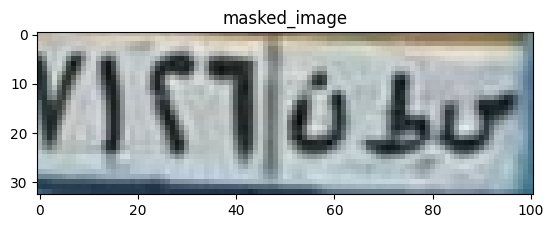

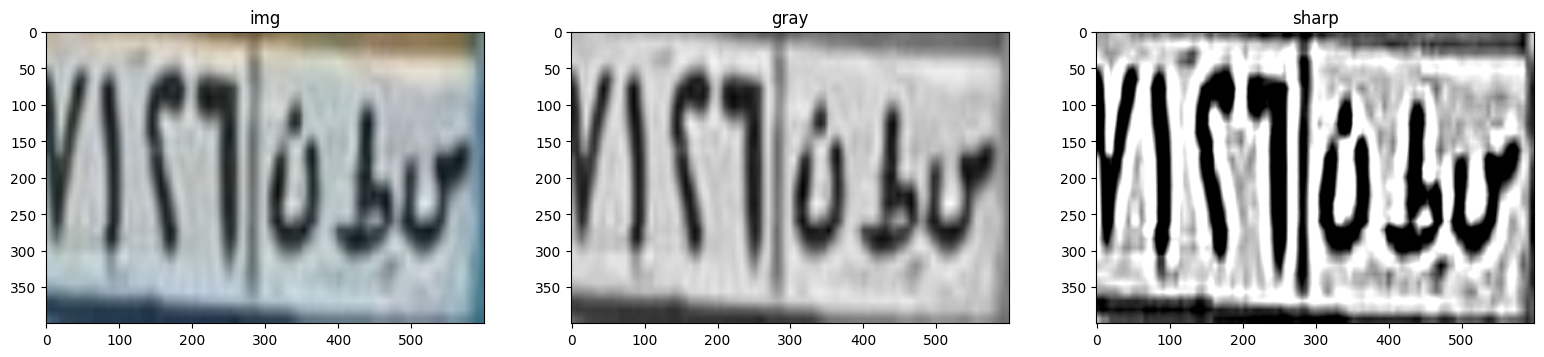

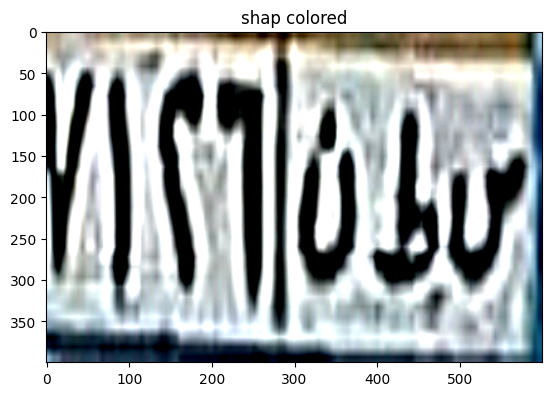

In [351]:
img = cv2.imread('Results3/0001.jpg', cv2.IMREAD_COLOR)

img_original = img.copy()   
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
image_copy = gray.copy()

img_threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

img_threshold = cv2.erode(img_threshold, np.ones((6, 6), np.uint8), iterations=1)
img_threshold = cv2.dilate(img_threshold, np.ones((1, 20), np.uint8), iterations=1)

contours, _ = cv2.findContours(img_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_contour)

aspect_ratio = w / h
print(aspect_ratio)
mask_found = True
# if 2.2 < aspect_ratio < 5:
#     mask = np.zeros_like(image_copy)
#     cv2.rectangle(mask, (x, y), (x + w, y + h), (255, 255, 255), -1)
#     masked_image = cv2.bitwise_and(image_copy, mask)
# else:
#     masked_image = image_copy
#     mask_found = False
#     print("No colored part detected. The whole image will be used.")
# if mask_found:
#     img = cv2.bitwise_and(img, img, mask=mask)
show_images([img], ['masked_image'])

img = cv2.resize(img, (600, 400))
gray = cv2.resize(gray, (600, 400))
# masked_image = cv2.resize(masked_image, (600, 400))

# gray = cv2.equalizeHist(gray)
# gray = cv2.GaussianBlur(gray, (5, 5), 10)
# gray = np.where(gray < 180, np.min(gray), gray)
# sharp = unsharp_mask(masked_image,10,5)
sharp = unsharp_mask(gray, 10, 5)
show_images([img,gray,sharp], ['img','gray','sharp'])
img = unsharp_mask(img, 10, 5)
show_images([img], ['shap colored'])




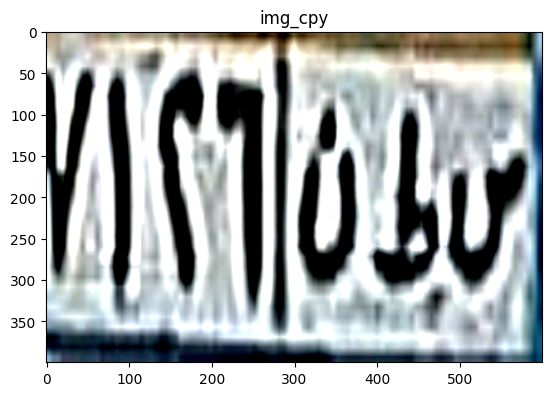

In [352]:
template = cv2.imread('template.jpg', cv2.IMREAD_GRAYSCALE)
result = cv2.matchTemplate(gray, template, cv2.TM_CCOEFF_NORMED)

threshold = 0.7
locations = np.where(result >= threshold)  # Get all positions with a match score above the threshold
template_height, template_width = template.shape[:2]
img_cpy = img.copy()
# Draw rectangles around all matches
for pt in zip(*locations[::-1]):  # Switch x and y positions
    bottom_right = (pt[0] + template_width, pt[1] + template_height)
    cv2.rectangle(img_cpy, pt, bottom_right, (0, 255, 0), 2)
show_images([img_cpy], ['img_cpy'])

In [353]:
def reduce_colors(img, n):
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = n
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))

    return res2

In [354]:
def clean_image(img):
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    resized_img = cv2.resize(gray_img, (600, 400))

    resized_img = cv2.GaussianBlur(resized_img,(5,5),0)
    # show_images([resized_img], ['resized_img'])

    equalized_img = cv2.equalizeHist(resized_img)
    # show_images([equalized_img], ['equalized_img'])


    reduced = cv2.cvtColor(reduce_colors(cv2.cvtColor(equalized_img, cv2.COLOR_GRAY2BGR), 8), cv2.COLOR_BGR2GRAY)
    # show_images([reduced], ['reduced'])

    ret, mask = cv2.threshold(reduced, 64, 255, cv2.THRESH_BINARY)
    # show_images([mask], ['mask'])

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    
    mask = cv2.erode(mask, kernel, iterations = 1)
    # show_images([mask], ['mask'])
     
    return mask

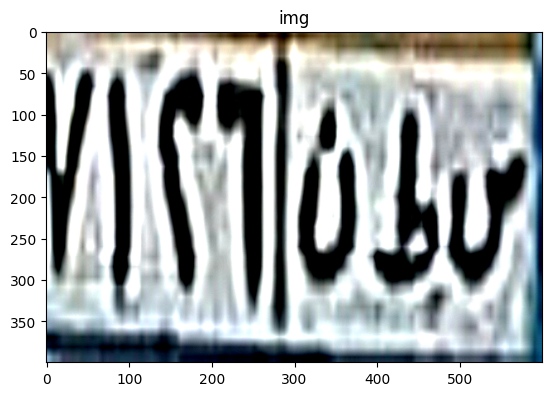

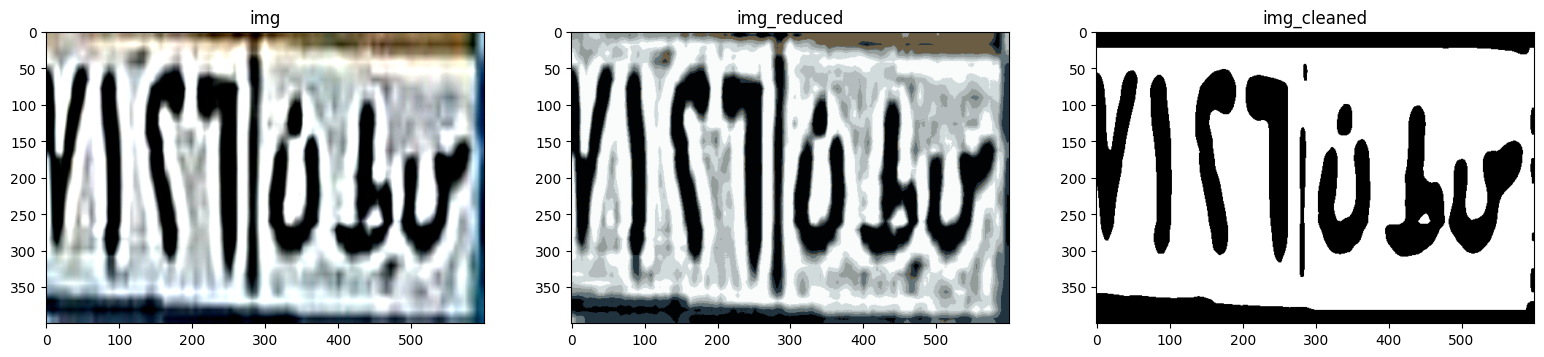

In [355]:
show_images([img], ['img'])
img_reduced = reduce_colors(img, 8)
img_cleaned = clean_image(img_original)
mask_resized = cv2.resize(mask, (600, 400))
if mask_found:
    img_cleaned = cv2.bitwise_and(img_cleaned, img_cleaned, mask=mask_resized)
# img_cleaned = cv2.bitwise_and(img_cleaned, img_cleaned, mask=)
show_images([img,img_reduced,img_cleaned], ['img','img_reduced','img_cleaned'])

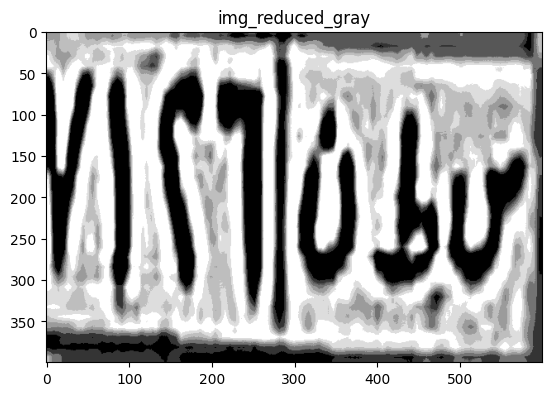

In [356]:
img_reduced_gray = cv2.cvtColor(img_reduced, cv2.COLOR_BGR2GRAY)
show_images([img_reduced_gray], ['img_reduced_gray'])

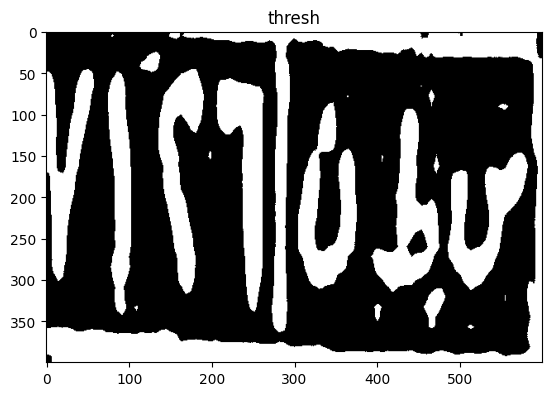

In [357]:
thresh = cv2.threshold(img_reduced_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
# thresh = img_cleaned
# show_images([thresh], ['thresh'])
thresh = cv2.bitwise_not(thresh)
show_images([thresh], ['thresh'])

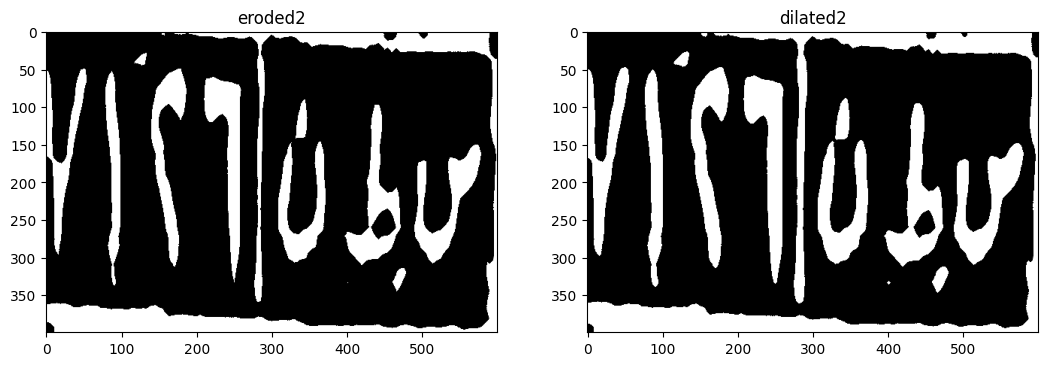

In [358]:
kernel_data = np.array([[0, 0, 1, 0, 0],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [0, 0, 1, 0, 0]], dtype=np.uint8)
eroded2 = cv2.erode(thresh, kernel_data, iterations=2)
dilated2 = cv2.dilate(eroded2, kernel_data, iterations=1)
show_images([eroded2, dilated2], ["eroded2", "dilated2"])

In [359]:
# contours, _ = cv2.findContours(eroded2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# img_draw = img.copy()
# for contour in contours:
#     x, y, w, h = cv2.boundingRect(contour)
#     cv2.rectangle(img_draw, (x, y), (x + w, y + h), (0, 255, 0), 2)
# show_images([img_draw], ['img_draw'])

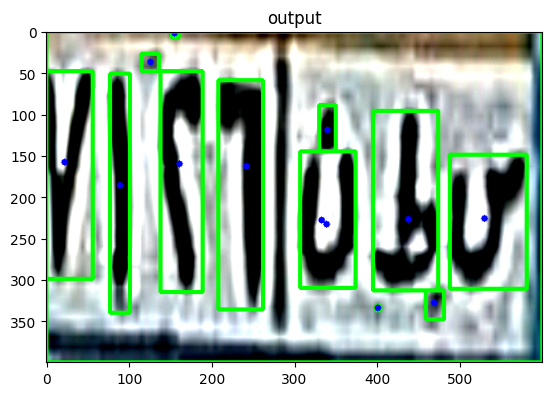

In [360]:
# get connected components and their stats
connectedComponents = cv2.connectedComponentsWithStats(
            dilated2, 8, cv2.CV_32S)
(numLabels, labels, stats, centroids) = connectedComponents
output = img.copy()

for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 3)
    cv2.circle(output, (int(cX), int(cY)), 4, (0, 0, 255), -1)
show_images([output], ["output"])

25
770
15066
11055
17143
1120
14958
6936
13617
14056
441
240000
64


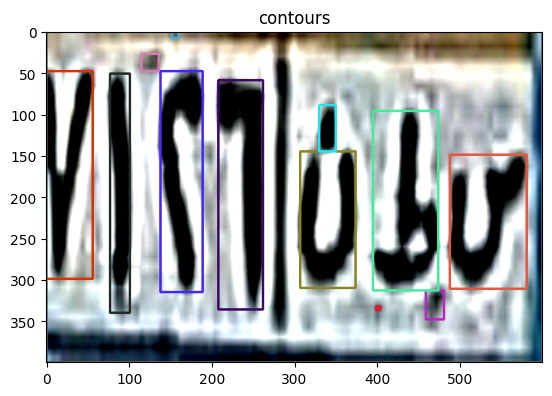

(400, 600, 3)
399 332 5 5
25 1.0
not filled
459 313 22 35
770 0.6285714285714286
filled
488 149 93 162
15066 0.5740740740740741
filled
307 145 67 165
11055 0.40606060606060607
filled
395 96 79 217
17143 0.3640552995391705
filled
330 89 20 56
1120 0.35714285714285715
filled
208 59 54 277
14958 0.19494584837545126
filled
77 51 24 289
6936 0.08304498269896193
filled
138 48 51 267
13617 0.19101123595505617
filled
0 48 56 251
14056 0.22310756972111553
filled
115 27 21 21
441 1.0
not filled
0 0 600 400
240000 1.5
not filled
152 0 8 8
64 1.0
not filled


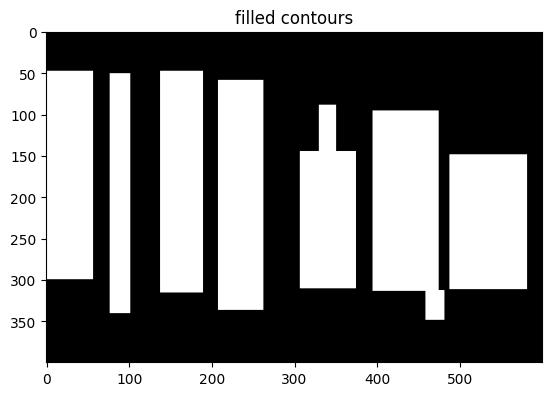

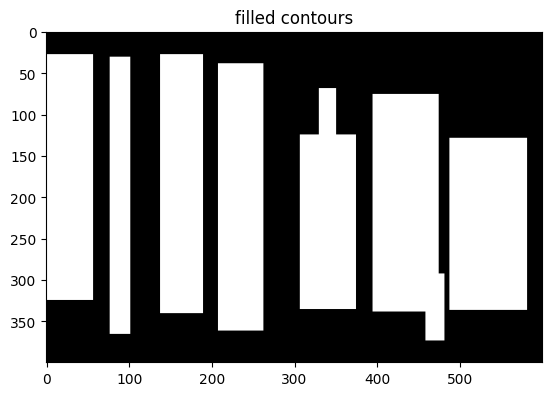

0.4519230769230769 19552
0.29194630872483224 25926
0.2546816479400749 18156
0.17027863777089783 17765
0.07462686567164178 8375
0.16613418530351437 16276
0.1919191919191919 16929


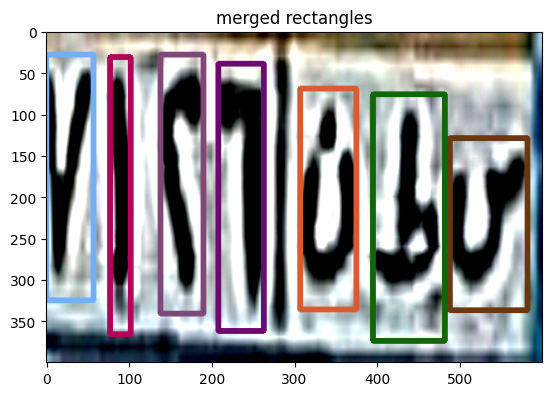

In [361]:
cnts = cv2.findContours(dilated2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#use 8 connectivity
cnts = imutils.grab_contours(cnts)
img_copy = img.copy()

for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    # random color
    print(w*h)
    color = np.random.randint(0, 255, size=(3,)).tolist()
    cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 2)
show_images([img_copy], ['contours'])
    
img_filled = np.zeros_like(img)
print(img_filled.shape)
for c in cnts:
    x, y, w, h = cv2.boundingRect(c)
    print(x,y,w,h)
    aspect_ratio = w/h
    area = w*h
    print(area, aspect_ratio)
    if 0 < aspect_ratio < 1.4 and 500 < area < 50000:
        cv2.rectangle(img_filled, (x,y), (x+w,y+h), (255,255,255), thickness=cv2.FILLED)
        print('filled')
    else:
        print('not filled')
show_images([img_filled], ['filled contours'])
img_filled = cv2.morphologyEx(img_filled, cv2.MORPH_DILATE,
                              cv2.getStructuringElement(cv2.MORPH_RECT, (1,10)),iterations=5)
img_filled = cv2.cvtColor(img_filled, cv2.COLOR_BGR2GRAY)
show_images([img_filled], ['filled contours'])

# find contours of filled image
cnts2 = cv2.findContours(img_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts2 = imutils.grab_contours(cnts2)
rectangles = []
for c in cnts2:
    (x, y, w, h) = cv2.boundingRect(c)
    rectangles.append((x,y,w,h))

img_copy = img.copy()
image_area = img.shape[0]*img.shape[1]
img_width = img.shape[1]
final_rectangles = []
for r in rectangles:
    if r is not None:
        (x, y, w, h) = r
        # random color
        aspect_ratio = w/h
        area = w*h
        print(aspect_ratio,area)
        if w < 0.6*h and 1500 < area < image_area/5 and  img_width/50< w:
            final_rectangles.append(r)
            color = np.random.randint(0, 255, size=(3,)).tolist()
            cv2.rectangle(img_copy, (x, y), (x + w, y + h), color, 5)
show_images([img_copy], ['merged rectangles'])

In [362]:
import os
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skimage import feature

#joblib is used to save the model
import joblib

In [363]:
def train_knn_model(data_set_path):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
            if file.endswith('.png'):
                char_path = os.path.join(data_set_path,dir,file)
                # check if file exists
                if not os.path.isfile(char_path):
                    continue
                try:
                    img = io.imread(char_path)
                except:
                    continue
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (20, 50))
                
                # extract hog features
                hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                      cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                # hog_img = img.flatten()/255
                x_train.append(hog_img)
                y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data_set, labels, test_size=0.2, random_state=1)
    
    # train model
    model = neighbors.KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train, y_train)
    
    # test model
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    
    
    return model
    

In [364]:
def compute_threshold(data_set_path,knn_model):
    # read images
    x_train = []
    y_train = []
    for dir in os.listdir(data_set_path):
        #label is directory name
        label = dir
        for file in os.listdir(os.path.join(data_set_path,dir)):
                if file.endswith('.png'):
                    char_path = os.path.join(data_set_path,dir,file)
                    # check if file exists
                    if not os.path.isfile(char_path):
                        continue
                    try:
                        img = io.imread(char_path)
                    except:
                        continue
                    if len(img.shape) == 3:
                        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    img = cv2.resize(img, (20, 50))
                    
                    #extract hog features
                    hog_img = feature.hog(img, orientations=9, pixels_per_cell=(8, 8),
                                        cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
                    x_train.append(hog_img)
                    y_train.append(label)
       
    data_set = np.array(x_train)
    labels = np.array(y_train)
    
    distances, _ = knn_model.kneighbors(data_set)
    
    threshold = np.mean(distances) + 2*np.std(distances)
    
    return threshold

In [365]:
# model = train_knn_model('Chars_DataSet')
# joblib.dump(model, 'model_2.pkl')

In [366]:
knn_model = joblib.load('model_2.pkl')

In [367]:
#print all classes in knn and the number of members in each class
print(knn_model.classes_)
#print number of memberts for Outliers class


['Outliers' 'أ' 'ب' 'ج' 'د' 'ر' 'س' 'ص' 'ط' 'ع' 'ف' 'ق' 'ل' 'م' 'ن' 'و'
 'ى' '١' '٢' '٣' '٤' '٥' '٦' '٧' '٨' '٩' 'ھ']


In [368]:
# model_threshold = compute_threshold('Chars_DataSet',knn_model)

In [369]:
# print(model_threshold)
model_threshold = 1.5

7
488
1.110420489527847
1.5
1.1585956397437425
['س']


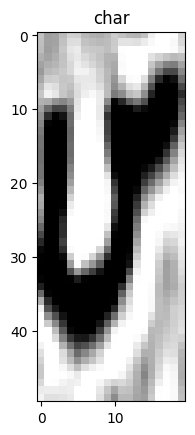

395
1.2604542183327472
1.5
1.280063540643357
['ط']


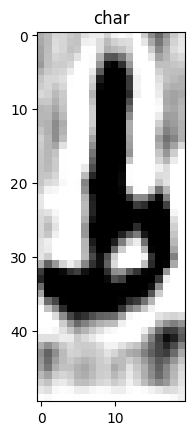

307
1.0850831903315192
1.5
1.0963212052468354
['ن']


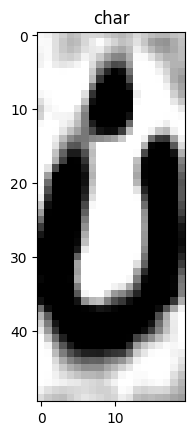

208
0.9205841374470853
1.5
0.9620510093096994
['٦']


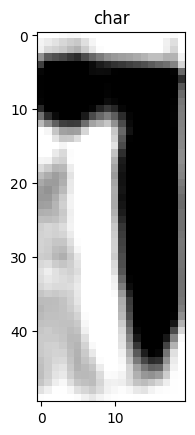

138
0.8974474126439297
1.5
0.9649683454754339
['٢']


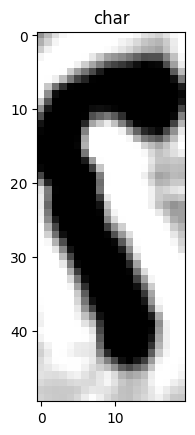

77
1.8198466883469864
0
0.948272581795024
1.5
0.9781801448758393
['٧']


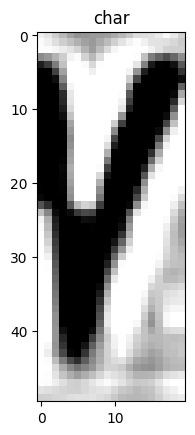

سطن٦٢٧


In [370]:
final_rectangles = sorted(final_rectangles, key=lambda x: -x[0])
license_plate = ''
print(len(final_rectangles))
for rectangle in final_rectangles:
    x, y, w, h = rectangle
    char_img = img[y:y+h, x:x+w]
    char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
    char_img = cv2.resize(char_img, (20, 50))
    #adaptive thresholding
    hog_img = feature.hog(char_img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")

    char = knn_model.predict([hog_img])
    print(x)
    distances, _ = knn_model.kneighbors([hog_img])
    nearest_distance = distances[0][0]
    print(nearest_distance)
    if nearest_distance > model_threshold or char[0] == 'Outliers':
        continue
    print(model_threshold)
    print(np.mean(distances))
    print(char)
    license_plate += char[0]
    show_images([char_img], ['char'])
    
#reverse license plate
print(license_plate)